In [1]:
import os
import numpy as np
import random as python_random
import tensorflow as tf 
SEED=56789
np.random.seed(SEED)
python_random.seed(SEED)
tf.compat.v1.random.set_random_seed(SEED)
os.environ['PYTHONHASHSEED']=str(SEED)
import pandas as pd
from PIL import Image
import sys
import tensorflow.keras
from tensorflow.keras import backend 
from tensorflow.keras.models import Sequential, load_model 
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, Masking, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow. keras.utils import plot_model 
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import roc_curve, auc, plot_precision_recall_curve, average_precision_score, precision_recall_curve
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

C:\anaconda3\envs\cnn\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\anaconda3\envs\cnn\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\anaconda3\envs\cnn\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\anaconda3\envs\cnn\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1)

In [2]:
classdata = pd.read_csv('200_Model_Data_Without_SMOTE.csv')
fps = classdata['FP']
X = []
Y = classdata['CLASS'].values
for i in range(0,len(fps)):
    cmap = {'1': 1, '2': 2}
    data = [cmap[letter] for letter in fps[i]]
    X.append(np.array(data).reshape(50, 4)) # 50*4
    
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=10, stratify=Y)  

In [3]:
udLearning_rate = 0.01

img_rows = 50
img_cols = 4

input_shape = (img_rows, img_cols, 1)
X_train = np.array(X_train)
X_test = np.array(X_test)
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)

X_train = X_train.astype('float32') / 1.5 # 255.
X_test = X_test.astype('float32') / 1.5 # 255.

print('x_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

batch_size = 32
num_classes = 2
epochs = 100

Y_train = tf.keras.utils.to_categorical(np.array(Y_train), num_classes=2)
Y_test = tf.keras.utils.to_categorical(np.array(Y_test), num_classes=2)

x_train shape: (2254, 50, 4, 1)
2254 train samples
967 test samples


In [4]:
model = Sequential()
model.add(Conv2D(5, kernel_size=(2, 2), strides=(1, 1), padding='same',
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(8, (4, 4), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

es = EarlyStopping(monitor='val_loss', patience=10, mode='min', min_delta=0.01)

model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(udLearning_rate), metrics=['accuracy'])
hist = model.fit(X_train, Y_train,
                 batch_size=batch_size,
                 validation_split = 0.2,
                 epochs=epochs, callbacks=[es])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 50, 4, 5)          25        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 25, 2, 5)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 2, 8)          648       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 1, 8)          0         
_________________________________________________________________
flatten (Flatten)            (None, 96)                0         
_________________________________________________________________
dense (Dense)                (None, 50)                4850      
____

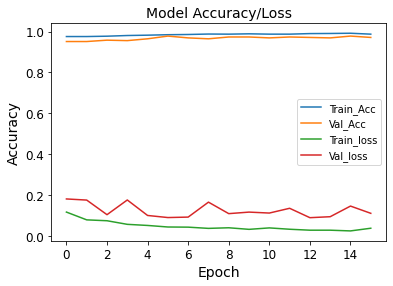

In [7]:
from matplotlib import pyplot as plt

plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Accuracy/Loss',fontsize=14)
plt.ylabel('Accuracy',fontsize=14)
plt.xlabel('Epoch',fontsize=14)
plt.tick_params(axis="y", labelsize=12) 
plt.tick_params(axis="x", labelsize=12) 
plt.legend(['Train_Acc', 'Val_Acc', 'Train_loss', 'Val_loss'], fontsize=10, loc='center right')
plt.show()

In [8]:
# Training and Test data score and accuracy
score_train = model.evaluate(X_train, Y_train, verbose =0)
score_test = model.evaluate(X_test, Y_test, verbose=0)

# Perfom the prediction on test set
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

acc_ts = accuracy_score(np.argmax(Y_test,axis=1), np.argmax(y_test_pred,axis=1))
mcc_ts = metrics.matthews_corrcoef(np.argmax(Y_test,axis=1), np.argmax(y_test_pred,axis=1))
roc_auc_ts = metrics.roc_auc_score(Y_test, y_test_pred, average=None)
roc_auc_ts_micro = metrics.roc_auc_score(Y_test, y_test_pred, average='micro',multi_class='ovr')
auPR_ts = average_precision_score(Y_test, y_test_pred, average=None)   
auPR_ts_micro = average_precision_score(Y_test, y_test_pred, average='micro')  
cm_tr = confusion_matrix(np.argmax(Y_train,axis=1), np.argmax(y_train_pred,axis=1))
cm_ts = confusion_matrix(np.argmax(Y_test,axis=1), np.argmax(y_test_pred,axis=1))
f1_ts = metrics.f1_score(np.argmax(Y_test,axis=1), np.argmax(y_test_pred,axis=1), average=None)

print("Accuracy_Train: %.4f" % score_train[1])
print("Train_loss: %.4f" % score_train[0])
print("Test_loss: %.4f" % score_test[0])
print("Accuracy_Test: %.4f" % acc_ts)
print("MCC_Test: %.4f" % mcc_ts)
print("ROC_AUC_Test:", roc_auc_ts)    
print("ROC_AUC_Test_MICRO: %.4f" % roc_auc_ts_micro)
print("auPR_Test:", auPR_ts)
print("auPR_Test_MICRO: %.4f" % auPR_ts_micro)
print("F1-Score_Test:", f1_ts)
print(classification_report(np.argmax(Y_test,axis=1), np.argmax(y_test_pred,axis=1)))
print("Confusion_Matrix Train:", cm_tr)
print("Confusion_Matrix Test:", cm_ts)

Accuracy_Train: 0.9854
Train_loss: 0.0446
Test_loss: 0.0750
Accuracy_Test: 0.9824
MCC_Test: 0.6375
ROC_AUC_Test: [0.93292773 0.93292773]
ROC_AUC_Test_MICRO: 0.9955
auPR_Test: [0.72389774 0.99706782]
auPR_Test_MICRO: 0.9952
F1-Score_Test: [0.58536585 0.99101955]
              precision    recall  f1-score   support

           0       1.00      0.41      0.59        29
           1       0.98      1.00      0.99       938

    accuracy                           0.98       967
   macro avg       0.99      0.71      0.79       967
weighted avg       0.98      0.98      0.98       967

Confusion_Matrix Train: [[  35   31]
 [   2 2186]]
Confusion_Matrix Test: [[ 12  17]
 [  0 938]]


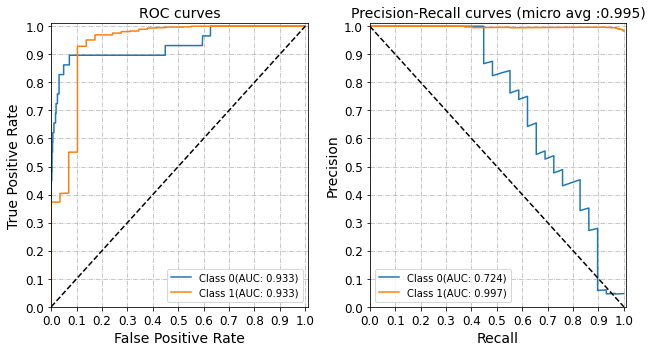

In [9]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], y_test_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
        
precision = dict()
recall = dict()
average_precision = dict()
    
for i in range(2):
    precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i], y_test_pred[:, i])
    average_precision[i] = average_precision_score(Y_test[:, i], y_test_pred[:, i])
    
precision["micro"], recall["micro"], _ = precision_recall_curve(Y_test.ravel(), y_test_pred.ravel())
average_precision["micro"] = average_precision_score(Y_test, y_test_pred, average="micro")
    
fig, ax = plt.subplots(1,2,figsize=(9,5))
    
for i, classes in zip(range(2), ['Class 0', 'Class 1']):
    ax[0].plot(fpr[i], tpr[i], label=classes+'(AUC: %0.3f)' % roc_auc[i], alpha=1)
ax[0].plot([0, 1], [0, 1],'k--')
ax[0].set_xlim([0.0, 1.01])
ax[0].set_ylim([0.0, 1.01])
ax[0].set_yticks(np.arange(0, 1.1, 0.1))
ax[0].set_xticks(np.arange(0, 1.1, 0.1))
ax[0].set_xlabel('False Positive Rate', fontsize=14)
ax[0].set_ylabel('True Positive Rate', fontsize=14)
ax[0].set_title('ROC curves', fontsize=14)
ax[0].grid(linestyle='-.', linewidth=0.7)
ax[0].tick_params(axis="y", labelsize=12) 
ax[0].tick_params(axis="x", labelsize=12)
ax[0].legend(fontsize=10, loc="lower right")

for i, classes in zip(range(2), ['Class 0', 'Class 1']):
    ax[1].plot(recall[i], precision[i], label=classes+'(AUC: %0.3f)' % average_precision[i], alpha=1)     

ax[1].plot([0, 1], [1, 0],'k--')
ax[1].set_xlim([0.0, 1.01])
ax[1].set_ylim([0.0, 1.01])
ax[1].set_yticks(np.arange(0, 1.1, 0.1))
ax[1].set_xticks(np.arange(0, 1.1, 0.1))
ax[1].set_xlabel('Recall', fontsize=14)
ax[1].set_ylabel('Precision', fontsize=14)
ax[1].set_title('Precision-Recall curves (micro avg :{0:0.3f})'.format(average_precision["micro"]), fontsize=14)
ax[1].grid(linestyle='-.', linewidth=0.7)
ax[1].tick_params(axis="y", labelsize=12) 
ax[1].tick_params(axis="x", labelsize=12)
ax[1].legend(fontsize=10, loc="lower left")
plt.tight_layout()